In [1]:
import numpy as np

from dmipy.core.acquisition_scheme import acquisition_scheme_from_bvalues
from dmipy.signal_models import cylinder_models, gaussian_models
from dmipy.core.modeling_framework import MultiCompartmentModel

import matplotlib.pyplot as plt

import config
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as utils
from tqdm import tqdm

import process_data

In [2]:
scan_100206 = process_data.get_nifti_data(config.data_folder2 + '/100206/data.nii.gz')
mask_100206 = process_data.get_nifti_data(config.data_folder2 + '/100206/nodif_brain_mask.nii.gz')

In [3]:
scan_dimension = scan_100206.shape
x = scan_dimension[0]
y = scan_dimension[1]
z = scan_dimension[2]
b = scan_dimension[3]

In [4]:
scan_100206_long = np.reshape(scan_100206, (x*y*z, b))

mask_100206_long = np.reshape(mask_100206, (x*y*z, 1))

In [5]:
# Error voxels
indice_beginning_0_all = np.where(scan_100206_long[:, 0] == 0)[0]

In [6]:
mask_100206_long_pro = np.copy(mask_100206_long)
mask_100206_long_pro[indice_beginning_0_all] = 0

In [7]:
scan_100206_long_no_background = process_data.remove_background(scan_100206_long, mask_100206_long_pro)

In [8]:
bvals_all_100206 = np.loadtxt(config.data_folder2 + '/100206/bvals')

In [9]:
S0_100206 = process_data.get_S0(scan_100206_long_no_background, bvals_all_100206*1e-3)

In [10]:
normalized_scan_100206_full = scan_100206_long_no_background / S0_100206

In [11]:
normalized_scan_100206_full.shape

(935442, 288)

In [31]:
rand_8g_bval_indice_100206 = np.array(process_data.get_rand_selected_bval_indice(bvals_all_100206, 8))

In [32]:
rand_8g_bval_indice_100206

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170,
       171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183,
       184, 185, 186, 187, 188, 189, 190, 224, 225, 226, 227, 228, 229,
       230, 231, 232, 233, 234, 235, 236, 237, 238, 239])

In [33]:
bvals_100206_8g = bvals_all_100206[rand_8g_bval_indice_100206]*1e-3

In [34]:
normalized_scan_100206_8g = normalized_scan_100206_full[:, rand_8g_bval_indice_100206]

In [35]:
big_b_indice_100206_8g = np.where(bvals_100206_8g != 0.005)[0]

In [36]:
big_b_indice_100206_8g

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,
        28,  29,  30,  31,  33,  34,  35,  36,  37,  38,  39,  40,  41,
        42,  43,  44,  45,  46,  47,  49,  50,  51,  52,  53,  54,  55,
        56,  57,  58,  59,  60,  61,  62,  63,  65,  66,  67,  68,  69,
        70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  81,  82,  83,
        84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  97,
        98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110,
       112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124,
       125, 126])

In [37]:
bvals_100206_8g_no_b5 = bvals_100206_8g[big_b_indice_100206_8g]

In [38]:
normalized_scan_100206_8g_no_b5 = normalized_scan_100206_8g[:, big_b_indice_100206_8g]

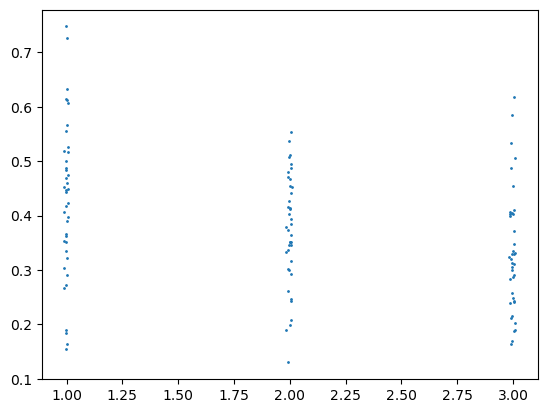

In [39]:
plt.plot(bvals_100206_8g_no_b5, normalized_scan_100206_8g_no_b5[42,:], "o", markersize = 1)

ANN

In [21]:
def squash(param, p_min, p_max):
    squashed_param_tensor =torch.clamp(param, min=p_min, max=p_max)
    unsqueezed_param = squashed_param_tensor.unsqueeze(1)
    return unsqueezed_param

In [22]:
def unitsphere2cart(theta, phi, X):
    mu_cart = torch.zeros(3,X.size()[0])
    sintheta = torch.sin(theta)
    mu_cart[0,:] = torch.squeeze(sintheta * torch.cos(phi))
    mu_cart[1,:] = torch.squeeze(sintheta * torch.sin(phi))
    mu_cart[2,:] = torch.squeeze(torch.cos(theta))
    return mu_cart

In [23]:
class BallStickNet(nn.Module):
    
    def __init__(self, gradient_directions, b_values):
        super(BallStickNet, self).__init__()
        self.gradient_directions = gradient_directions
        self.b_values = b_values
        self.fc_layers = nn.ModuleList()
        for i in range(3): 
            self.fc_layers.extend([nn.Linear(len(b_values), len(b_values)), nn.ELU()])
        self.encoder = nn.Sequential(*self.fc_layers, nn.Linear(len(b_values), 5))
        # if args.dropout != 0:
        #     self.dropout = nn.Dropout(args.dropout)
            
    def forward(self, X):
        # if args.dropout != 0:
        #     X = self.dropout(X)
        params = torch.abs(self.encoder(X))
        theta_uns = params[:, 0]
        theta = theta_uns.unsqueeze(1)
        phi_uns = params[:, 1]
        phi = phi_uns.unsqueeze(1)
        mu_cart = unitsphere2cart(theta, phi, X)
        mm_prod =  torch.einsum("ij,jk->ki",self.gradient_directions, mu_cart)
        lambda_par_uns = params[:, 2]
        lambda_par = squash(lambda_par_uns, 0.1, 3.0)
        lambda_iso_uns = params[:, 3]
        lambda_iso = squash(lambda_iso_uns, 0.1, 3.0)
        volume_0_uns = params[:, 4]
        volume_0 = squash(volume_0_uns, 0.01, 0.99)
        volume_1 = 1-volume_0
        X = volume_0 * torch.exp(-self.b_values * lambda_par * mm_prod ** 2) + volume_1 * torch.exp(-self.b_values * lambda_iso)
        return X, theta, phi, mu_cart, lambda_par, lambda_iso, volume_0, volume_1

In [40]:
n_100206_all = np.loadtxt(config.data_folder2 + '/100206/bvecs')
n_100206_8g = n_100206_all[:, rand_8g_bval_indice_100206]

In [41]:
print(n_100206_8g.shape)
print(big_b_indice_100206_8g)

(3, 127)
[  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  17  18  19
  20  21  22  23  24  25  26  27  28  29  30  31  33  34  35  36  37  38
  39  40  41  42  43  44  45  46  47  49  50  51  52  53  54  55  56  57
  58  59  60  61  62  63  65  66  67  68  69  70  71  72  73  74  75  76
  77  78  79  81  82  83  84  85  86  87  88  89  90  91  92  93  94  95
  97  98  99 100 101 102 103 104 105 106 107 108 109 110 112 113 114 115
 116 117 118 119 120 121 122 123 124 125 126]


In [42]:
n_100206_8g_no_b5 = n_100206_8g[:,big_b_indice_100206_8g].T
print(n_100206_8g_no_b5.shape)

b_values_100206_8g_no_b5 = torch.FloatTensor(bvals_100206_8g_no_b5)
gradient_directions_100206_8g_no_b5 = torch.FloatTensor(n_100206_8g_no_b5)

net = BallStickNet(gradient_directions_100206_8g_no_b5, b_values_100206_8g_no_b5)

criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr = 0.00001)

(119, 3)


In [43]:
batch_size = 128
num_batches = len(normalized_scan_100206_8g_no_b5) // batch_size
trainloader = utils.DataLoader(torch.from_numpy(normalized_scan_100206_8g_no_b5.astype(np.float32)),
                            batch_size = batch_size, 
                            shuffle = True,
                            num_workers = 2,
                            drop_last = True)

In [44]:
loss_list=[]
avg_loss_list=[]

counter = 0

# Best loss
best = 1e16
num_bad_epochs = 0
patience = 10

for epoch in range(1000):
    print("-----------------------------------------------------------------")
    print("Epoch: {}; Bad epochs: {}".format(epoch, num_bad_epochs))
    net.train()
    running_loss = 0.

    for i, X_batch in enumerate(tqdm(trainloader), 0):
        optimizer.zero_grad()
        X_pred, theta, phi, mu_cart_pred, lambda_par_pred, lambda_iso_pred, volume_0_pred, volume_1_pred = net(X_batch)
        if i == 100 and counter == 10:
            print("X_batch: ")
            print(X_batch.shape)
            print(X_batch)
            print("X_pred: ")
            print(X_pred.shape)
            print(X_pred)
        loss = criterion(X_pred.type(torch.FloatTensor), X_batch.type(torch.FloatTensor))
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
    loss_list.append(running_loss)
    avg_loss_list.append(running_loss/num_batches)
    print("Loss: {}".format(running_loss))
    print("Average Loss: {}".format(running_loss/num_batches))
    

    if running_loss < best:
        print("############### Saving good model ###############################")
        final_model = net.state_dict()
        best = running_loss
        num_bad_epochs = 0
    else:
        num_bad_epochs = num_bad_epochs + 1
        if num_bad_epochs == patience:
            print("Done, best loss: {}".format(best))
            break
    counter += 1

print("Done") 
net.load_state_dict(final_model)

-----------------------------------------------------------------
Epoch: 0; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:40<00:00, 179.29it/s]


Loss: 2611.343014240265
Average Loss: 0.3573266303010762
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 1; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:40<00:00, 180.21it/s]


Loss: 2608.9829917550087
Average Loss: 0.3570036934530663
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 2; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:35<00:00, 206.80it/s]


Loss: 2608.7419140934944
Average Loss: 0.356970705267309
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 3; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 212.38it/s]


Loss: 2607.6900501847267
Average Loss: 0.35682677205592866
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 4; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:35<00:00, 208.61it/s]


Loss: 2607.8501572310925
Average Loss: 0.35684868051875923
-----------------------------------------------------------------
Epoch: 5; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 197.63it/s]


Loss: 2607.575588643551
Average Loss: 0.35681110955713613
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 6; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 224.04it/s]


Loss: 2607.0043733119965
Average Loss: 0.35673294653968207
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 7; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 275.46it/s]


Loss: 2607.614992260933
Average Loss: 0.35681650140406856
-----------------------------------------------------------------
Epoch: 8; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 276.57it/s]


Loss: 2607.0081751048565
Average Loss: 0.3567334667631166
-----------------------------------------------------------------
Epoch: 9; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 236.05it/s]


Loss: 2242.757885605097
Average Loss: 0.30689078894432087
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 10; Bad epochs: 0


  2%|██▉                                                                                                                                                           | 135/7308 [00:03<00:57, 125.78it/s]

X_batch: 
torch.Size([128, 119])
tensor([[0.4106, 0.1865, 0.0921,  ..., 0.3695, 0.2186, 0.0884],
        [0.5979, 0.2465, 0.2493,  ..., 0.5724, 0.3121, 0.1455],
        [0.2550, 0.1502, 0.0996,  ..., 0.2948, 0.1114, 0.1139],
        ...,
        [0.1029, 0.0289, 0.0232,  ..., 0.1325, 0.0497, 0.0158],
        [0.4002, 0.3141, 0.1211,  ..., 0.3599, 0.2199, 0.1901],
        [0.3673, 0.2334, 0.1576,  ..., 0.3448, 0.1707, 0.1705]])
X_pred: 
torch.Size([128, 119])
tensor([[0.9820, 0.3754, 0.1202,  ..., 0.2600, 0.7462, 0.1253],
        [0.9705, 0.4391, 0.2067,  ..., 0.3506, 0.7483, 0.2108],
        [0.9870, 0.3468, 0.0803,  ..., 0.2185, 0.7416, 0.0857],
        ...,
        [0.9930, 0.3574, 0.0095,  ..., 0.1901, 0.7360, 0.0196],
        [0.9775, 0.3956, 0.1461,  ..., 0.2882, 0.7366, 0.1506],
        [0.9805, 0.3826, 0.1292,  ..., 0.2698, 0.7425, 0.1340]],
       grad_fn=<AddBackward0>)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 195.59it/s]


Loss: 965.4238403774798
Average Loss: 0.1321050684698248
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 11; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 196.01it/s]


Loss: 463.1819681455381
Average Loss: 0.06338012700404189
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 12; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 218.80it/s]


Loss: 454.4550084369257
Average Loss: 0.06218596174561107
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 13; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 200.06it/s]


Loss: 453.3145687985234
Average Loss: 0.062029908155244035
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 14; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:44<00:00, 165.31it/s]


Loss: 452.0219853105955
Average Loss: 0.06185303575678647
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 15; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 238.28it/s]


Loss: 451.210942145437
Average Loss: 0.061742055575456624
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 16; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 224.59it/s]


Loss: 450.13152492325753
Average Loss: 0.061594352069411266
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 17; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:35<00:00, 205.84it/s]


Loss: 449.8552884804085
Average Loss: 0.061556552884566025
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 18; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:35<00:00, 204.54it/s]


Loss: 448.9217527769506
Average Loss: 0.061428811272160724
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 19; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:35<00:00, 208.11it/s]


Loss: 447.9977085846476
Average Loss: 0.06130236844343837
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 20; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 201.66it/s]


Loss: 445.3514404799789
Average Loss: 0.060940262791458526
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 21; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 209.92it/s]


Loss: 437.15337931597605
Average Loss: 0.05981847007607773
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 22; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 200.73it/s]


Loss: 430.70931031461805
Average Loss: 0.05893668723516941
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 23; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:35<00:00, 204.50it/s]


Loss: 428.3591681616381
Average Loss: 0.058615102375703075
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 24; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 200.85it/s]


Loss: 426.8354687206447
Average Loss: 0.05840660491524969
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 25; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:35<00:00, 203.19it/s]


Loss: 425.9096163851209
Average Loss: 0.058279914666820046
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 26; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 201.65it/s]


Loss: 425.50950544700027
Average Loss: 0.05822516494896008
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 27; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:35<00:00, 204.47it/s]


Loss: 424.62818115600385
Average Loss: 0.05810456775533714
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 28; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:35<00:00, 207.61it/s]


Loss: 424.02143073664047
Average Loss: 0.05802154224639306
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 29; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:35<00:00, 205.45it/s]


Loss: 424.4524676965084
Average Loss: 0.05808052376799513
-----------------------------------------------------------------
Epoch: 30; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:35<00:00, 208.18it/s]


Loss: 423.7933166602161
Average Loss: 0.05799032795022114
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 31; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:35<00:00, 208.40it/s]


Loss: 423.7833593557589
Average Loss: 0.05798896542908578
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 32; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:35<00:00, 206.11it/s]


Loss: 423.2735932653304
Average Loss: 0.05791921090111254
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 33; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:35<00:00, 205.87it/s]


Loss: 423.6961418967694
Average Loss: 0.05797703091088799
-----------------------------------------------------------------
Epoch: 34; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 187.55it/s]


Loss: 423.0803321360145
Average Loss: 0.057892765754791256
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 35; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 219.18it/s]


Loss: 422.4600025729742
Average Loss: 0.0578078821254754
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 36; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 221.73it/s]


Loss: 422.1398640021216
Average Loss: 0.057764075533952054
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 37; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 221.15it/s]


Loss: 421.78398807602935
Average Loss: 0.05771537877340303
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 38; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 216.59it/s]


Loss: 421.48022755538113
Average Loss: 0.05767381329438713
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 39; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 223.11it/s]


Loss: 421.1979187747929
Average Loss: 0.057635183193047744
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 40; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 219.11it/s]


Loss: 420.895575200906
Average Loss: 0.057593811603845926
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 41; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 225.14it/s]


Loss: 420.34008301910944
Average Loss: 0.05751780008471667
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 42; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 223.25it/s]


Loss: 420.18998891394585
Average Loss: 0.05749726175615023
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 43; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 221.50it/s]


Loss: 419.6774011608213
Average Loss: 0.0574271211221704
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 44; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 223.79it/s]


Loss: 419.56832271511666
Average Loss: 0.05741219522648011
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 45; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 220.81it/s]


Loss: 419.20328325754963
Average Loss: 0.0573622445617884
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 46; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 221.26it/s]


Loss: 418.630897335941
Average Loss: 0.05728392136507129
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 47; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 215.24it/s]


Loss: 418.3329410383012
Average Loss: 0.057243150114710074
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 48; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 219.10it/s]


Loss: 418.080584238749
Average Loss: 0.05720861853294321
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 49; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 195.89it/s]


Loss: 417.8040920321364
Average Loss: 0.057170784350319706
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 50; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 193.89it/s]


Loss: 417.79232216835953
Average Loss: 0.05716917380519424
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 51; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 202.12it/s]


Loss: 417.33520242082886
Average Loss: 0.05710662321029404
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 52; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 217.90it/s]


Loss: 416.99353577941656
Average Loss: 0.057059870796307685
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 53; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 212.34it/s]


Loss: 416.8877639370039
Average Loss: 0.05704539736412204
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 54; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 212.60it/s]


Loss: 416.7642557686195
Average Loss: 0.05702849695793917
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 55; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 200.29it/s]


Loss: 416.2564858959522
Average Loss: 0.05695901558510567
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 56; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:35<00:00, 204.29it/s]


Loss: 416.4536073356867
Average Loss: 0.056985988962190294
-----------------------------------------------------------------
Epoch: 57; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 247.89it/s]


Loss: 416.0331209411379
Average Loss: 0.05692845114137081
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 58; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 246.23it/s]


Loss: 416.35218805796467
Average Loss: 0.05697211111904278
-----------------------------------------------------------------
Epoch: 59; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 243.58it/s]


Loss: 415.7979881176725
Average Loss: 0.056896276425516215
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 60; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 244.71it/s]


Loss: 415.849521294469
Average Loss: 0.05690332803700999
-----------------------------------------------------------------
Epoch: 61; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 244.73it/s]


Loss: 415.56679669884034
Average Loss: 0.0568646410370608
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 62; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 242.80it/s]


Loss: 415.3719245821703
Average Loss: 0.056837975449120184
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 63; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 244.72it/s]


Loss: 415.65390399401076
Average Loss: 0.056876560480844385
-----------------------------------------------------------------
Epoch: 64; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 243.88it/s]


Loss: 415.13592438562773
Average Loss: 0.056805682045105055
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 65; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 240.00it/s]


Loss: 415.1455052506644
Average Loss: 0.056806993055646474
-----------------------------------------------------------------
Epoch: 66; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 247.07it/s]


Loss: 414.83499115589075
Average Loss: 0.05676450344224011
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 67; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 248.69it/s]


Loss: 414.44244359014556
Average Loss: 0.05671078866860229
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 68; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 245.39it/s]


Loss: 414.60937233641744
Average Loss: 0.05673363058790605
-----------------------------------------------------------------
Epoch: 69; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 247.08it/s]


Loss: 414.3550642328337
Average Loss: 0.056698831996830006
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 70; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 244.13it/s]


Loss: 414.1496961056255
Average Loss: 0.05667073017318356
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 71; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 245.09it/s]


Loss: 414.09517253166996
Average Loss: 0.05666326936667624
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 72; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 248.87it/s]


Loss: 414.01286521879956
Average Loss: 0.056652006734920574
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 73; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 243.40it/s]


Loss: 413.73540399968624
Average Loss: 0.05661403995616943
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 74; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 243.94it/s]


Loss: 413.84872831520624
Average Loss: 0.05662954684116123
-----------------------------------------------------------------
Epoch: 75; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 241.65it/s]


Loss: 413.7967798281461
Average Loss: 0.05662243840012946
-----------------------------------------------------------------
Epoch: 76; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 209.82it/s]


Loss: 413.535097069107
Average Loss: 0.056586630688164614
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 77; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 221.02it/s]


Loss: 413.5679233102128
Average Loss: 0.056591122510976026
-----------------------------------------------------------------
Epoch: 78; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 234.64it/s]


Loss: 413.33216004120186
Average Loss: 0.05655886152725805
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 79; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:35<00:00, 204.17it/s]


Loss: 413.05785264610313
Average Loss: 0.05652132630625385
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 80; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 215.20it/s]


Loss: 413.0244539841078
Average Loss: 0.05651675615546084
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 81; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 222.56it/s]


Loss: 413.1959235921968
Average Loss: 0.05654021942969305
-----------------------------------------------------------------
Epoch: 82; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 214.55it/s]


Loss: 413.00199618027546
Average Loss: 0.05651368311169615
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 83; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 219.31it/s]


Loss: 413.13948141783476
Average Loss: 0.05653249608892101
-----------------------------------------------------------------
Epoch: 84; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 217.09it/s]


Loss: 412.91099125216715
Average Loss: 0.056501230330072136
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 85; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 211.96it/s]


Loss: 412.7549431109801
Average Loss: 0.056479877272985785
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 86; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 212.99it/s]


Loss: 412.7551067173481
Average Loss: 0.05647989966028299
-----------------------------------------------------------------
Epoch: 87; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:35<00:00, 208.48it/s]


Loss: 412.73679140908644
Average Loss: 0.056477393460466124
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 88; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 215.87it/s]


Loss: 412.5740169500932
Average Loss: 0.056455119998644394
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 89; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 217.78it/s]


Loss: 412.498457015492
Average Loss: 0.05644478065346087
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 90; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 212.28it/s]


Loss: 412.4169348436408
Average Loss: 0.056433625457531576
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 91; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 216.69it/s]


Loss: 412.67410556110553
Average Loss: 0.05646881575822462
-----------------------------------------------------------------
Epoch: 92; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 216.33it/s]


Loss: 412.1724406790454
Average Loss: 0.05640016976998432
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 93; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 221.02it/s]


Loss: 412.2323171184398
Average Loss: 0.056408363043026793
-----------------------------------------------------------------
Epoch: 94; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 215.23it/s]


Loss: 412.20487713231705
Average Loss: 0.056404608255653674
-----------------------------------------------------------------
Epoch: 95; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 212.06it/s]


Loss: 412.25564119173214
Average Loss: 0.05641155462393707
-----------------------------------------------------------------
Epoch: 96; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 219.87it/s]


Loss: 412.2532318602316
Average Loss: 0.0564112249398237
-----------------------------------------------------------------
Epoch: 97; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 212.64it/s]


Loss: 412.0644736229442
Average Loss: 0.05638539595278383
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 98; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 211.49it/s]


Loss: 412.07532623480074
Average Loss: 0.05638688098451023
-----------------------------------------------------------------
Epoch: 99; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 216.44it/s]


Loss: 412.18013500305824
Average Loss: 0.056401222633149735
-----------------------------------------------------------------
Epoch: 100; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 219.69it/s]


Loss: 412.11508542788215
Average Loss: 0.056392321487121255
-----------------------------------------------------------------
Epoch: 101; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 214.28it/s]


Loss: 411.87850809749216
Average Loss: 0.0563599491102206
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 102; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 214.48it/s]


Loss: 411.93767515337095
Average Loss: 0.05636804531381649
-----------------------------------------------------------------
Epoch: 103; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 216.40it/s]


Loss: 411.81739607453346
Average Loss: 0.05635158676444081
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 104; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 216.90it/s]


Loss: 411.90121135977097
Average Loss: 0.05636305574162164
-----------------------------------------------------------------
Epoch: 105; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 221.80it/s]


Loss: 411.64692064584233
Average Loss: 0.05632825953008242
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 106; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 202.97it/s]


Loss: 411.83546376624145
Average Loss: 0.05635405908131383
-----------------------------------------------------------------
Epoch: 107; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 220.16it/s]


Loss: 411.69813074194826
Average Loss: 0.05633526693239577
-----------------------------------------------------------------
Epoch: 108; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 216.72it/s]


Loss: 411.73942260537297
Average Loss: 0.05634091716001272
-----------------------------------------------------------------
Epoch: 109; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 214.49it/s]


Loss: 411.7024575788528
Average Loss: 0.05633585900093771
-----------------------------------------------------------------
Epoch: 110; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 212.27it/s]


Loss: 411.5145423710346
Average Loss: 0.05631014537096807
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 111; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 216.83it/s]


Loss: 411.7611490553245
Average Loss: 0.056343890127986386
-----------------------------------------------------------------
Epoch: 112; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 213.02it/s]


Loss: 411.580464548897
Average Loss: 0.05631916592075766
-----------------------------------------------------------------
Epoch: 113; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 215.06it/s]


Loss: 411.5138221846428
Average Loss: 0.0563100468232954
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 114; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 213.30it/s]


Loss: 411.4329509243835
Average Loss: 0.056298980695728446
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 115; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 211.31it/s]


Loss: 411.4414014215581
Average Loss: 0.05630013703086455
-----------------------------------------------------------------
Epoch: 116; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 215.56it/s]


Loss: 411.55947566311806
Average Loss: 0.056316293878368645
-----------------------------------------------------------------
Epoch: 117; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 217.22it/s]


Loss: 411.2689246253576
Average Loss: 0.056276535936693704
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 118; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 216.77it/s]


Loss: 411.3147965297103
Average Loss: 0.05628281288036539
-----------------------------------------------------------------
Epoch: 119; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 213.77it/s]


Loss: 411.22137247002684
Average Loss: 0.05627002907362162
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 120; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 215.43it/s]


Loss: 411.4723412198946
Average Loss: 0.05630437071974474
-----------------------------------------------------------------
Epoch: 121; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 216.04it/s]


Loss: 411.15959570743144
Average Loss: 0.05626157576730042
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 122; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:35<00:00, 208.54it/s]


Loss: 411.3784527371172
Average Loss: 0.056291523363042856
-----------------------------------------------------------------
Epoch: 123; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 214.43it/s]


Loss: 411.23917430453
Average Loss: 0.05627246501156678
-----------------------------------------------------------------
Epoch: 124; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 217.65it/s]


Loss: 411.2475661775097
Average Loss: 0.056273613324782396
-----------------------------------------------------------------
Epoch: 125; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 210.67it/s]


Loss: 411.04409582866356
Average Loss: 0.056245771186188225
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 126; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 215.10it/s]


Loss: 411.0897300741635
Average Loss: 0.05625201560949145
-----------------------------------------------------------------
Epoch: 127; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 213.08it/s]


Loss: 411.23815933358856
Average Loss: 0.05627232612665416
-----------------------------------------------------------------
Epoch: 128; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 218.73it/s]


Loss: 411.0045857937075
Average Loss: 0.05624036477746408
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 129; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 210.82it/s]


Loss: 410.9774785202462
Average Loss: 0.05623665551727507
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 130; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 214.42it/s]


Loss: 410.986533857882
Average Loss: 0.05623789461656842
-----------------------------------------------------------------
Epoch: 131; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 215.24it/s]


Loss: 411.2763958054129
Average Loss: 0.05627755826565584
-----------------------------------------------------------------
Epoch: 132; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 213.50it/s]


Loss: 410.9858430142049
Average Loss: 0.05623780008404555
-----------------------------------------------------------------
Epoch: 133; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 211.33it/s]


Loss: 410.80064719659276
Average Loss: 0.056212458565488885
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 134; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 218.24it/s]


Loss: 410.93825381132774
Average Loss: 0.05623128815152268
-----------------------------------------------------------------
Epoch: 135; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 212.47it/s]


Loss: 411.0457061517518
Average Loss: 0.05624599153691185
-----------------------------------------------------------------
Epoch: 136; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 190.40it/s]


Loss: 410.8939667569939
Average Loss: 0.05622522807293294
-----------------------------------------------------------------
Epoch: 137; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 189.06it/s]


Loss: 410.8502945553046
Average Loss: 0.056219252128531
-----------------------------------------------------------------
Epoch: 138; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 201.41it/s]


Loss: 410.78577743750066
Average Loss: 0.05621042384202253
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 139; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 211.94it/s]


Loss: 410.6822382914834
Average Loss: 0.0561962559238483
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 140; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:43<00:00, 166.24it/s]


Loss: 410.77665549353696
Average Loss: 0.056209175628562806
-----------------------------------------------------------------
Epoch: 141; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:43<00:00, 168.18it/s]


Loss: 410.7696352347266
Average Loss: 0.05620821500201513
-----------------------------------------------------------------
Epoch: 142; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:43<00:00, 169.31it/s]


Loss: 410.6256022138987
Average Loss: 0.05618850605006823
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 143; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 215.06it/s]


Loss: 410.79004035820253
Average Loss: 0.056211007164505
-----------------------------------------------------------------
Epoch: 144; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 213.96it/s]


Loss: 410.80534209124744
Average Loss: 0.05621310099770764
-----------------------------------------------------------------
Epoch: 145; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:35<00:00, 203.52it/s]


Loss: 410.6513794392813
Average Loss: 0.05619203331134118
-----------------------------------------------------------------
Epoch: 146; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:35<00:00, 208.06it/s]


Loss: 410.5991832325235
Average Loss: 0.05618489097325171
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 147; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 208.93it/s]


Loss: 410.64952813019045
Average Loss: 0.056191779984974065
-----------------------------------------------------------------
Epoch: 148; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 209.15it/s]


Loss: 410.66949302889407
Average Loss: 0.05619451190871566
-----------------------------------------------------------------
Epoch: 149; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:35<00:00, 208.61it/s]


Loss: 410.5610324994195
Average Loss: 0.056179670566423034
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 150; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:35<00:00, 207.07it/s]


Loss: 410.68889960460365
Average Loss: 0.056197167433580136
-----------------------------------------------------------------
Epoch: 151; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 209.03it/s]


Loss: 410.55121770408005
Average Loss: 0.05617832754571429
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 152; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 196.91it/s]


Loss: 410.7530343537219
Average Loss: 0.056205943398155704
-----------------------------------------------------------------
Epoch: 153; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 198.57it/s]


Loss: 410.5809713292401
Average Loss: 0.056182398922993995
-----------------------------------------------------------------
Epoch: 154; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 209.80it/s]


Loss: 410.59434388391674
Average Loss: 0.056184228774482314
-----------------------------------------------------------------
Epoch: 155; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 209.22it/s]


Loss: 410.51275329315104
Average Loss: 0.056173064216358926
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 156; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:35<00:00, 208.41it/s]


Loss: 410.6198264765553
Average Loss: 0.05618771571928781
-----------------------------------------------------------------
Epoch: 157; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:35<00:00, 208.31it/s]


Loss: 410.53981437766925
Average Loss: 0.05617676715622184
-----------------------------------------------------------------
Epoch: 158; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 211.25it/s]


Loss: 410.5089563385118
Average Loss: 0.05617254465496877
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 159; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:35<00:00, 207.43it/s]


Loss: 410.59325368353166
Average Loss: 0.05618407959544768
-----------------------------------------------------------------
Epoch: 160; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:35<00:00, 204.40it/s]


Loss: 410.5606774231419
Average Loss: 0.05617962197908346
-----------------------------------------------------------------
Epoch: 161; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 199.67it/s]


Loss: 410.46860067150556
Average Loss: 0.056167022533046736
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 162; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 209.19it/s]


Loss: 410.3725095128175
Average Loss: 0.056153873770226806
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 163; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 215.32it/s]


Loss: 410.5425222357735
Average Loss: 0.05617713768962418
-----------------------------------------------------------------
Epoch: 164; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 216.59it/s]


Loss: 410.51716682408005
Average Loss: 0.056173668147794203
-----------------------------------------------------------------
Epoch: 165; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 210.50it/s]


Loss: 410.3351713682059
Average Loss: 0.05614876455503639
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 166; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 218.76it/s]


Loss: 410.299973644549
Average Loss: 0.056143948227223454
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 167; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 210.52it/s]


Loss: 410.3634572569281
Average Loss: 0.05615263509262836
-----------------------------------------------------------------
Epoch: 168; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 202.60it/s]


Loss: 410.4530673446134
Average Loss: 0.0561648970093888
-----------------------------------------------------------------
Epoch: 169; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 209.43it/s]


Loss: 410.26539248856716
Average Loss: 0.056139216268276844
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 170; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 201.94it/s]


Loss: 408.22251305799
Average Loss: 0.05585967611630952
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 171; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 213.81it/s]


Loss: 410.2145792138763
Average Loss: 0.056132263165555044
-----------------------------------------------------------------
Epoch: 172; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 209.13it/s]


Loss: 410.31198356533423
Average Loss: 0.05614559162087222
-----------------------------------------------------------------
Epoch: 173; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 214.02it/s]


Loss: 410.2454226575792
Average Loss: 0.056136483669619486
-----------------------------------------------------------------
Epoch: 174; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 214.15it/s]


Loss: 410.2766408456955
Average Loss: 0.056140755452339285
-----------------------------------------------------------------
Epoch: 175; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 201.51it/s]


Loss: 410.2284477588255
Average Loss: 0.05613416088653879
-----------------------------------------------------------------
Epoch: 176; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 211.70it/s]


Loss: 410.3083752549719
Average Loss: 0.056145097872875194
-----------------------------------------------------------------
Epoch: 177; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 210.13it/s]


Loss: 410.1747093964368
Average Loss: 0.05612680752551133
-----------------------------------------------------------------
Epoch: 178; Bad epochs: 7


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 211.87it/s]


Loss: 410.15214008954354
Average Loss: 0.05612371922407547
-----------------------------------------------------------------
Epoch: 179; Bad epochs: 8


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 212.57it/s]


Loss: 410.1853522625752
Average Loss: 0.056128263856400545
-----------------------------------------------------------------
Epoch: 180; Bad epochs: 9


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:35<00:00, 207.51it/s]

Loss: 410.2142105726525
Average Loss: 0.05613221272203784
Done, best loss: 408.22251305799
Done


<All keys matched successfully>

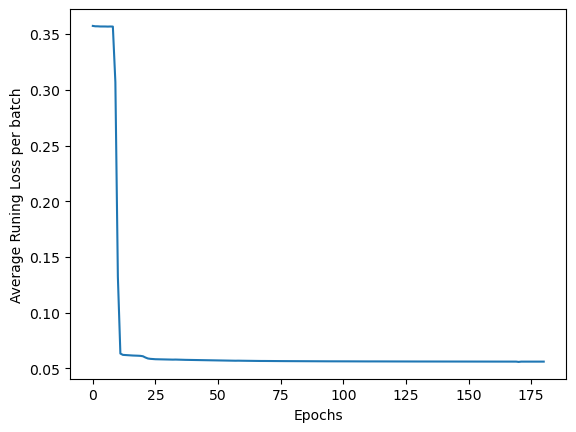

In [45]:
epoch_arr = np.arange(0, len(avg_loss_list))
loss_arr = np.array(avg_loss_list)
plt.plot(avg_loss_list)
plt.xlabel("Epochs")
plt.ylabel("Average Runing Loss per batch")
plt.show()

In [46]:
torch.save(final_model, 'model_100206_8g_03.pt')